## Introduction
This notebook demoes the gdgtm workflow, from gathering a collection of rasters, through their alignment and matching. The main point is to simplify the process of acquiring raster data from online sources and building a straightforward pipeline for their processing and standardization ahead of downstream analysis. As of version 0.5 of the package the get functions are written for OpenLandMap STAC (https://stac.openlandmap.org/) and Chelsa (https://chelsa-climate.org/).

The core workflow of this package is:
1. Get a raster from an online source
2. Process it to the desired projection, resolution and bounding box - this is the **Master GeoTIFF**
3. Get further rasters (**complementary rasters**) and align those to the Master

The result is a collection of GeoTIFF files that is standardized in terms of projection, bounding box, resolution, and exact pixel location.

In [5]:
## Import packages required for the demo. Note that these are not specified in gdgtm dependencies!!!
import gdgtm
import os
import rasterio
import matplotlib.pyplot as plt

In [2]:
## Set up the folder structure for the demo:
core_path = "/home/pete/Documents/tests_and_vals/gdgtm_demo/" ## Change to whatever local directory you want to run the demo in.
raw_folder = "01_raw_geotiffs"
master_reprojected = "02_reprojected_geotiffs"
master_rescaled = "03_rescaled_geotiffs"
master_rebound = "04_rebound_geotiffs"
complimentary_aligned = "05_aligned_geotiffs"
mosaic_merge_out = "06_merged_geotiffs"

## Create demo folders:
os.mkdir(core_path)
os.mkdir(core_path + raw_folder)
os.mkdir(core_path + master_reprojected)
os.mkdir(core_path + master_rescaled)
os.mkdir(core_path + master_rebound)
os.mkdir(core_path + complimentary_aligned)
os.mkdir(core_path + mosaic_merge_out)


FileExistsError: [Errno 17] File exists: '/home/pete/Documents/tests_and_vals/gdgtm_demo/'

## Setting up Master GeoTIFF

This section is concerned with getting a raster (in this particular case from https://chelsa-climate.org/) and re-formatting it to the Master version.

#### get_chelsa_daily

This function creates urls for Chelsa daily data and downloads the .tiffs associated with those urls.

The function takes on the following arguments:
* parameter: the climate data of interest. Legitimate values can be found at: file:///home/pete/Downloads/chelsa_file_specification_bioclim_plus.pdf

* bbox: what extent of the map do we want to download? Note that "as-is" Chelsa uses degrees and degree fractions within the WGS84 coordinate system. The function assumes that the edge locations are provided in the **West-North-East-South** order, which is the standard used throughout gdgtm. Each bbox needs to be provided in the coordinate system of the raster being downloaded (which for Chelsa is WGS84).

* interval: Chelsa daily data comes as daily rasters. The interval argument set the boundaries for the days that the data is to refer to.

* dst_name: location to which the raster will get saved.

In [4]:
bbox_wgs84 = (5.7663, 47.9163, 10.5532, 45.6755) ### Bounding box in WGS84 coords. 

gdgtm.get_chelsa_daily(parameter = "tas", 
                                bbox = bbox_wgs84, 
                                interval = ("2023-1-1", "2023-1-1"), ## Interval (inclusive) for which days to download. Here only one file will be downloaded.
                                dst_path = core_path + raw_folder,
                                dst_name = "/chelsa_tas_"
                               )


['File exists: /home/pete/Documents/tests_and_vals/gdgtm_demo/01_raw_geotiffs/chelsa_tas_01_01_2023.tif']

Visualize the output raster using rasterio and matplotlib to confirm that the output raster indeed exists and whether it points at the target area (should be roughly Switzerland).

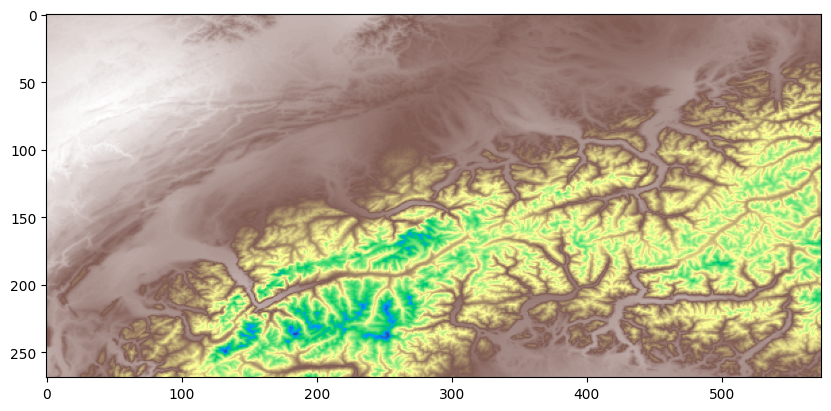

In [5]:
with rasterio.open(core_path + raw_folder + "/chelsa_tas_01_01_2023.tif") as target:
    target_data = target.read()
    
    plt.figure(figsize=(10, 10))
    plt.imshow(target_data[0], cmap='terrain') # For single-band raster
    # plt.imshow(data.transpose(1, 2, 0)) # For multi-band raster
    plt.show()

#### Reproject raster

Next we move to reprojecting the raster from WGS84 to World_Cassini projection. This projection results in substantial visual deformation to the raster in question and thus allowsus to check that the function works.

Following arguments are required:
* new_crs: name of the new coordinate system that we want to reproject to. Uses the authority:number SRID format.
* source_raster: path and name of the file containing the raster that we want to reproject.
* dst_raster: path and name of the file where the raster will be saved after re-projection.

There is also an optional argument on whether to delete the source GeoTIFF, which is set by default to True if the output file is produced. This applies to all functions in the gdgtm package that ingest source rasters.


In [6]:
gdgtm.reproject_raster(new_crs = "ESRI:54028", 
                       src_raster = core_path + raw_folder + "/chelsa_tas_01_01_2023.tif",
                       dst_raster = core_path + master_reprojected + "/chelsa_daily_tas.tif"
                      )

print("Source file retained: " + str(os.path.exists(core_path + raw_folder + "/chelsa_tas_01_01_2023.tif")))


Source file retained: False


Let's visualize the re-projected raster. Note that with the ESRI:54028 (World_Cassini) projection, the raster became somewhat deformed, confirming that the function is working as intended.

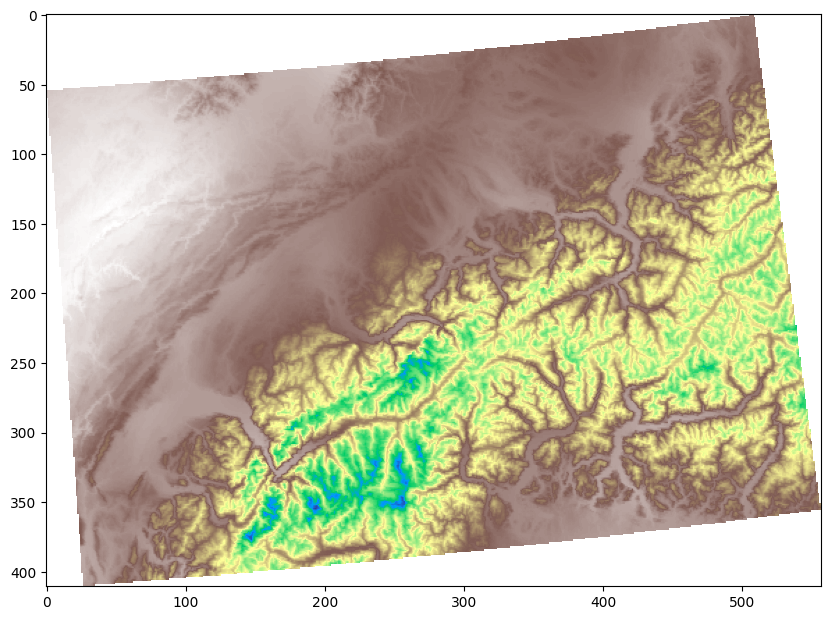

In [7]:
with rasterio.open(core_path + master_reprojected + "/chelsa_daily_tas.tif") as target:
    target_data = target.read(masked = True) ##Masking to ensure correct handling of nodata values around the reprojected edges.
    
    plt.figure(figsize=(10, 10))
    plt.imshow(target_data[0], cmap='terrain') # For single-band raster
    # plt.imshow(data.transpose(1, 2, 0)) # For multi-band raster
    plt.show()

#### Return to the original projection
We can test how well the reprojection works, by reverting back to the original projection:

In [ ]:
gdgtm.reproject_raster(new_crs = "EPSG:4326", 
                       src_raster = core_path + master_reprojected + "/chelsa_daily_tas.tif",
                       dst_raster = core_path + master_reprojected + "/chelsa_daily_tas_revert.tif",
                       delete_source = False
                      )


with rasterio.open(core_path + master_reprojected + "/chelsa_daily_tas_revert.tif") as target:
    target_data = target.read(masked = True) ##Masking to ensure correct handling of nodata values around the reprojected edges.
    
    plt.figure(figsize=(10, 10))
    plt.imshow(target_data[0], cmap='terrain') # For single-band raster
    # plt.imshow(data.transpose(1, 2, 0)) # For multi-band raster
    plt.show()

#### change_raster_res

Next we aim to change the resolution of the raster in question. The function used, change_raster_res, is a rasterio wrapper, which requires three obligatory arguments:
* target_res: the new resolution we want to use - effectively the size of the edge of the pixel in real life. **This needs to be provided in the same units as the grid underpinning the raster**: *if the grid is set up in metres, the units provided need to be meters, and if the grid is set up in degrees, the units need to be provided in degrees*.
* source and destination raster location, as was the case previously.

As a general rule, to limit the risk of artefacts occuring, raster resolution should take place after re-projection. The function uses Nearest Neighbour re-sampling implemented in GDAL.

In [8]:
gdgtm.change_raster_res(target_res = 2500, ###Spec what this is, V 0.9 include standardization
                        src_raster = core_path + master_reprojected + "/chelsa_daily_tas.tif",
                        dst_raster = core_path + master_rescaled + "/chelsa_daily_tas.tif",
                       )

print("Source file retained: " + str(os.path.exists(core_path + master_reprojected + "/chelsa_daily_tas.tif")))

Source file retained: False


Let's visualize the data, seeing increased pixel size, thus confirming that the intended rescaling really happened. 

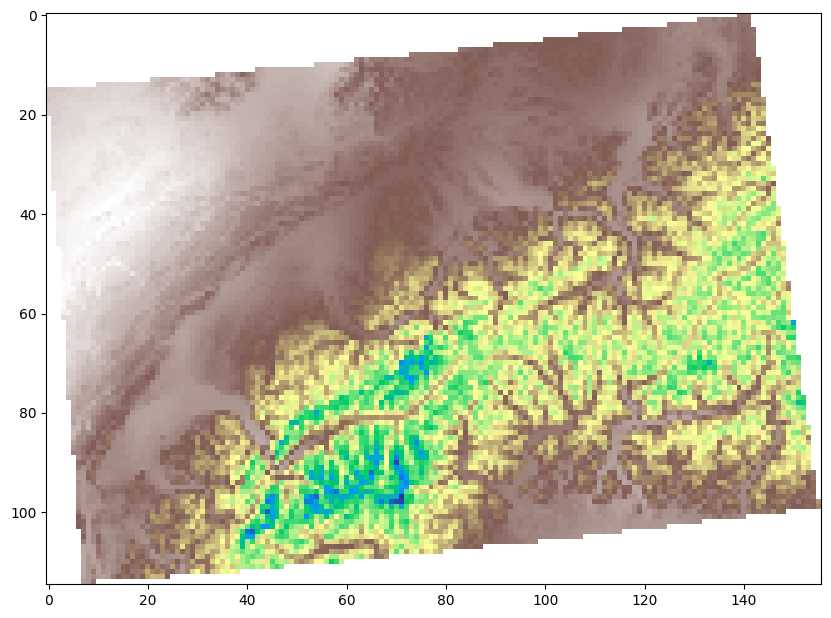

In [9]:
with rasterio.open(core_path + master_rescaled + "/chelsa_daily_tas.tif") as target:
    target_data = target.read(masked = True)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(target_data[0], cmap='terrain') # For single-band raster
    # plt.imshow(data.transpose(1, 2, 0)) # For multi-band raster
    plt.show()

#### set_raster_boundbox()

Now that the rasters have been re-projected and rescaled, we can set a new bounding box (i.e. "crop" the raster").

The function follows similar syntax to that already used elsewhere in this package, with the *target_bb* argument being a tuple of coordinates defining the West, North, East and South edges of the box coordinates.

Note that the automated file deletion will only take place when there is a good overlap between the intended bounding box and what GDAL (which this function really is just a wrapper for) could produce without introducing arbitrary offsets. In general, the higher the resolution, the smaller the change of the 1% check used to determine this being triggered and hence of the source not being deleted. The destination gets printed regardless.

In [3]:
new_bb = (515000, 5350000, 700000, 5100000) # This bbox is in the ESRI:54028 projection, with the units being meters from the datum.
gdgtm.set_raster_boundbox(target_bbox = new_bb,
                          src_raster = core_path + master_rescaled + "/chelsa_daily_tas.tif",
                          dst_raster = core_path + master_rebound + "/chelsa_daily_tas.tif",
                          delete_source = False
                         )

print("Source file retained: " + str(os.path.exists(core_path + master_rescaled + "/chelsa_daily_tas.tif")))


Source file retained: True


In the visualization we can see that the new bounding box got implemented.

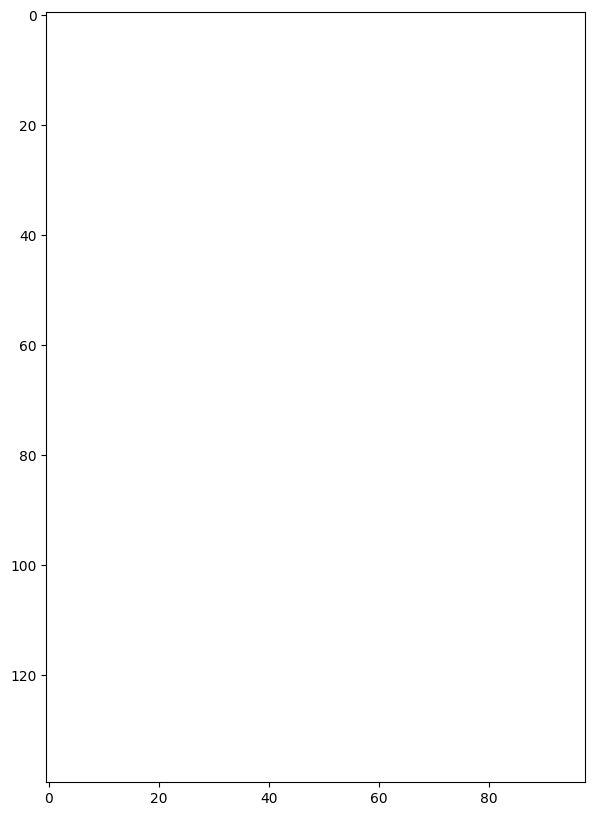

In [6]:
with rasterio.open(core_path + master_rebound + "/chelsa_daily_tas.tif") as target:
    target_data = target.read(masked = True)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(target_data[0], cmap='terrain') # For single-band raster
    # plt.imshow(data.transpose(1, 2, 0)) # For multi-band raster
    plt.show()

## Get complementary rasters

Here we shall get some more resters from different sources: OLM land-use and human footprint data, as well as Chelsa 1980-2010 Growing season length, and average precipitation for the month of June over the same time period

Unlike Chelsa, which is unique in the way it structures and records information, OLM uses the STAC framework (https://stacspec.org/en/), meaning that, these functions should be extendable across a range of static STAC contexts, which minimum amending.

#### get_cognames_from_stac_coll_static
The first thing to do is to get the names of the individual files (Cloud Optimized GeoTIFFs, or COGs) from STAC-based resources, such as OLM. This is acheived by providing the get_cognames function the link to the collection .json file, which is a STAC standard file that contains, among other things, this ckind of information.

The function only requires a link to the collection.json file and returns a list of URLs to the relevant rasters.

In [3]:
hum_foot_url = gdgtm.get_cognames_from_stac_coll_static("https://s3.eu-central-1.wasabisys.com/stac/openlandmap/wilderness_li2022.human.footprint/collection.json")

In [4]:
print(hum_foot_url)


['https://s3.openlandmap.org/arco/wilderness_li2022.human.footprint_p_1km_s_20000101_20001231_go_epsg.4326_v16022022.tif', 'https://s3.openlandmap.org/arco/wilderness_li2022.human.footprint_p_1km_s_20010101_20011231_go_epsg.4326_v16022022.tif', 'https://s3.openlandmap.org/arco/wilderness_li2022.human.footprint_p_1km_s_20020101_20021231_go_epsg.4326_v16022022.tif', 'https://s3.openlandmap.org/arco/wilderness_li2022.human.footprint_p_1km_s_20030101_20031231_go_epsg.4326_v16022022.tif', 'https://s3.openlandmap.org/arco/wilderness_li2022.human.footprint_p_1km_s_20040101_20041231_go_epsg.4326_v16022022.tif', 'https://s3.openlandmap.org/arco/wilderness_li2022.human.footprint_p_1km_s_20050101_20051231_go_epsg.4326_v16022022.tif', 'https://s3.openlandmap.org/arco/wilderness_li2022.human.footprint_p_1km_s_20060101_20061231_go_epsg.4326_v16022022.tif', 'https://s3.openlandmap.org/arco/wilderness_li2022.human.footprint_p_1km_s_20070101_20071231_go_epsg.4326_v16022022.tif', 'https://s3.openlandmap

In [13]:
alc_url = gdgtm.get_cognames_from_stac_coll_static("https://s3.eu-central-1.wasabisys.com/stac/openlandmap/land.cover_esacci.lc.l4/collection.json")

In [15]:
print(hum_foot_url)

['https://s3.openlandmap.org/arco/wilderness_li2022.human.footprint_p_1km_s_20000101_20001231_go_epsg.4326_v16022022.tif', 'https://s3.openlandmap.org/arco/wilderness_li2022.human.footprint_p_1km_s_20010101_20011231_go_epsg.4326_v16022022.tif', 'https://s3.openlandmap.org/arco/wilderness_li2022.human.footprint_p_1km_s_20020101_20021231_go_epsg.4326_v16022022.tif', 'https://s3.openlandmap.org/arco/wilderness_li2022.human.footprint_p_1km_s_20030101_20031231_go_epsg.4326_v16022022.tif', 'https://s3.openlandmap.org/arco/wilderness_li2022.human.footprint_p_1km_s_20040101_20041231_go_epsg.4326_v16022022.tif', 'https://s3.openlandmap.org/arco/wilderness_li2022.human.footprint_p_1km_s_20050101_20051231_go_epsg.4326_v16022022.tif', 'https://s3.openlandmap.org/arco/wilderness_li2022.human.footprint_p_1km_s_20060101_20061231_go_epsg.4326_v16022022.tif', 'https://s3.openlandmap.org/arco/wilderness_li2022.human.footprint_p_1km_s_20070101_20071231_go_epsg.4326_v16022022.tif', 'https://s3.openlandmap

#### get_cogs_from_olm

This is the function that gets the rasters from an OLM STAC collection. It takes on a list of of raster locations (begotten in the previous step with the get_cognames_from_stac_coll_statitc) and iterates over them, downloading each raster in the collection. The raster bounding boxes can be defined in advance (strongly advised for memory management purposes) and it is also possible to set interval limiting the time span over which the data were collected - which takes advantage of the OLM convention of putting timestamps into filenames and thus limits the number of files downloaded.

Here the bounding box is set to cover Switzerland and the time intervals are designed to catch 2003 and 2004 data. The function requries a path to the target directory where the data will be stored, as well as a core name for individual rasters. This will be later modified with a standardized time stamp.

In [18]:

gdgtm.get_cogs_from_olm(cognames = hum_foot_url, 
                        target_directory = core_path + raw_folder, 
                        target_names = "/olm_humfoot_",
                        bbox = bbox_wgs84,
                        interval = ("20020601", "20050101") ##Interval specifies which years dates will be downloaded
                       )

gdgtm.get_cogs_from_olm(cognames = hum_foot_url[0], ### Can also download a single specific file
                        target_directory = core_path + raw_folder, 
                        target_names = "/olm_humfoot_2000",
                        bbox = bbox_wgs84
                       )

gdgtm.get_cogs_from_olm(cognames = alc_url, 
                        target_directory = core_path + raw_folder, 
                        target_names = "/olm_alc_",
                        bbox = bbox_wgs84,
                        interval = ("20020601", "20050101"),
                       )

/home/pete/Documents/tests_and_vals/gdgtm_demo/01_raw_geotiffs/olm_humfoot_2000.tif


Let's visualize two of the downloaded rasters.

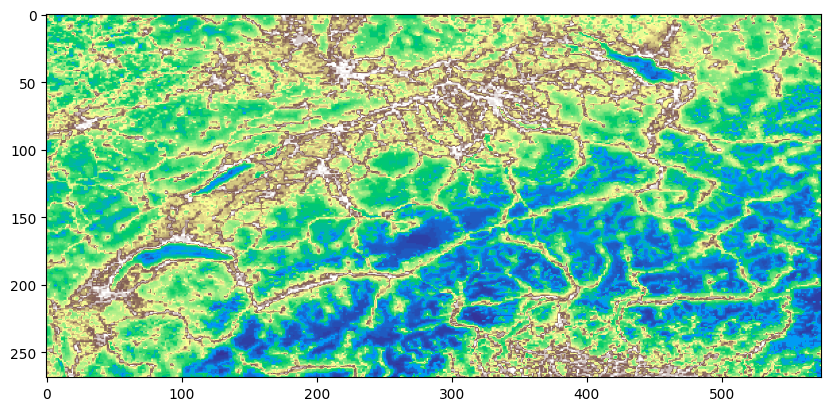

In [19]:
with rasterio.open(core_path + raw_folder + "/olm_humfoot_2000.tif") as target:
    target_data = target.read()
    
    plt.figure(figsize=(10, 10))
    plt.imshow(target_data[0], cmap='terrain') # For single-band raster
    # plt.imshow(data.transpose(1, 2, 0)) # For multi-band raster
    plt.show()

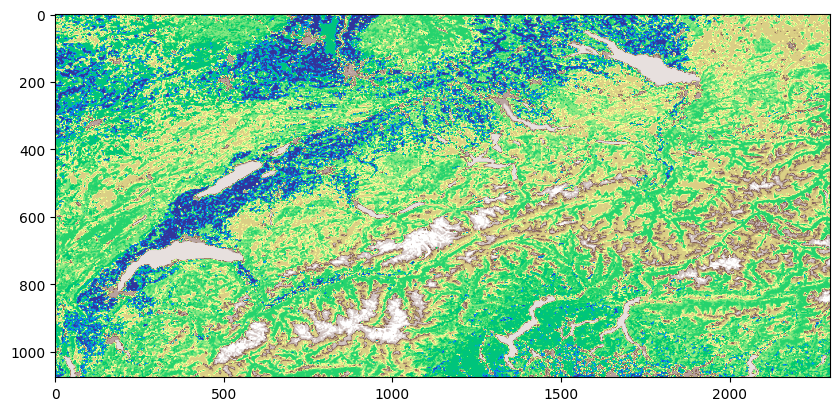

In [20]:
with rasterio.open(core_path + raw_folder + "/olm_alc_20030101.tif") as target:
    target_data = target.read()
    
    plt.figure(figsize=(10, 10))
    plt.imshow(target_data[0], cmap='terrain') # For single-band raster
    # plt.imshow(data.transpose(1, 2, 0)) # For multi-band raster
    plt.show()

# ADD to DEMO: FInding meaning from docs

As some of these rasters refer to the same type of data over the same area, only at different time points, under some circumstances it might be useful to convert those into a single multi-band raster. This can be done using the merge_rasters function.

In [ ]:
gdgtm.merge_rasters(raster_1 = core_path + raw_folder + "/olm_humfoot_20030101.tif", 
                    raster_2 = core_path + raw_folder + "/olm_humfoot_20040101.tif",
                    dst_raster = core_path + mosaic_merge_out +"/olm_humfott_20030101_20040101.tif",
                    delete_source = False) ## Here set to "False" as the intention is to use the raw files in the next step.


with rasterio.open(core_path + mosaic_merge_out +"/olm_humfott_20030101_20040101.tif") as target:
    target_data = target.read()
    
    plt.figure(figsize=(10, 10))
    plt.imshow(target_data[0], cmap='terrain') # For single-band raster
    # plt.imshow(data.transpose(1, 2, 0)) # For multi-band raster
    plt.show()

To complement the OLM data, we can also get some further rasters from Chelsa, this time using the climatology, rather then the time-series data. With respoect to the climatological data, Chelsa provides 1980-2010 historical averages, as well as 2010-2040 projections based on different models. As of the 0.x versions of gdgtm only the historical data get functions are implemented, however amending the underpinning functions should be fairly easy, as all that is required is changing the relevant root URLs (these can be accessed here: https://envicloud.wsl.ch/#/?prefix=chelsa%2Fchelsa_V2%2FGLOBAL%2F). 

As stated beforehand, we shall try to download length of growth season data and June precipitation data. These are abbreviated "gsl" and "pr" (see Chelsa documentation).

File exists: /home/pete/Documents/tests_and_vals/gdgtm_demo/01_raw_geotiffs/chelsa_bio_gsl.tif


Warning 1: for band 1, nodata value has been clamped to 0, the original value being out of range.


File exists: /home/pete/Documents/tests_and_vals/gdgtm_demo/01_raw_geotiffs/chelsa_clim_pr_jun.tif


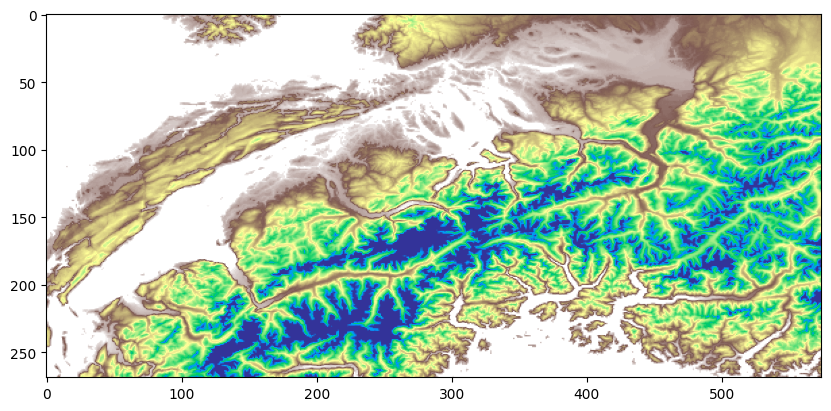

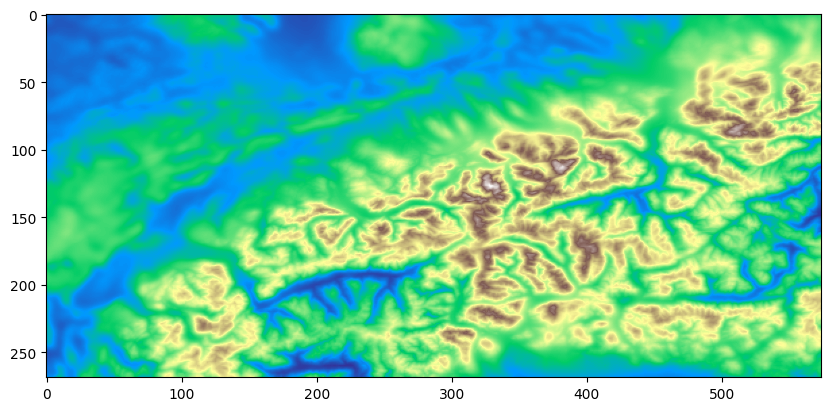

In [21]:
bbox = (5.7663, 47.9163, 10.5532, 45.6755)

gdgtm.get_chelsa_bio_19812010_data("gsl", bbox = bbox, dst_raster = core_path + raw_folder + "/chelsa_bio_gsl.tif") ## Explain args
gdgtm.get_chelsa_clim_19812010_data("pr", "06", bbox = bbox, dst_raster = core_path + raw_folder + "/chelsa_clim_pr_jun.tif")  ### More baisic function - give url/path to a file, just give data

## Visualize the results
with rasterio.open(core_path + raw_folder + "/chelsa_bio_gsl.tif") as target:
    target_data = target.read()
    plt.figure(figsize=(10, 10))
    plt.imshow(target_data[0], cmap='terrain') # For single-band raster
    plt.show()

with rasterio.open(core_path + raw_folder + "/chelsa_clim_pr_jun.tif") as target:
    target_data = target.read()
    plt.figure(figsize=(10, 10))
    plt.imshow(target_data[0], cmap='terrain') # For single-band raster
    plt.show()

Now that we have collected a range of rasters, we can finalize the workflow by aligning them onto the Master GeoTIFF projection, resolution and bounding box.

This is done using the align_validate_raster function. This function takes on three arguments (excluding the optional delete_soruce). First of the three arguments is the source raster (i.e. the raster that we want to align). Second is the target_raster (i.e. the master GeoTIFF). Third is the dst_raster - filename of where the new raster will be located.

align_validate_raster takes the source raster, checks if re-projection is necessary (if so it executes it using a call to gdgtm.reproject_raster), aligns the source to the Master, and concludes by running a check whether dimensions, projection, pixel count and geotransform match between the aligned and the target files.

In [ ]:
## Prepare a list of names of source rasters
raster_names = os.listdir(core_path + raw_folder)
src_rasters = []

for name in raster_names:
    src_rasters.append(core_path + raw_folder + "/" + name)

## Prepare a list of names of destination rasters
dst_rasters = []

for name in raster_names:
    dst_rasters.append(core_path + complimentary_aligned + "/" + name)


## Transform into a list of lists
rasters_to_process = []
for i in range(len(src_rasters)):
    rasters_to_process.append([src_rasters[i], dst_rasters[i]])



In [ ]:

for raster in rasters_to_process:
    outcome = gdgtm.align_validate_raster(source_raster = raster[0],
                                          target_raster = core_path + master_rebound + "/chelsa_daily_tas.tif",
                                          dst_raster = raster[1])

    print(outcome)
    print("Source file retained: " + str(os.path.exists(raster[0])))
    with rasterio.open(raster[1]) as target:
        target_data = target.read()
    
        plt.figure(figsize=(10, 10))
        plt.imshow(target_data[0], cmap='terrain') # For single-band raster
        # plt.imshow(data.transpose(1, 2, 0)) # For multi-band raster
        plt.show()

In [ ]:
### Clear DEMO files:
# os.remove(core_path)